In [1]:
import keras
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.applications import VGG19

In [3]:
model = VGG19(weights='imagenet', include_top=False)

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [5]:
def generate_pattern(layer_name, filter_index, size):
    
    layer_output = model.get_layer(layer_name).output
    
    # define loss function
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    # compute the gradients
    grads = K.gradients(loss, model.input)[0]
    
    # normalization trick
    grads //= (K.sqrt(K.sum(K.square(grads))) + 1e-5)
    
    # generate the random image + noise
    random_input = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # define the iterator
    iterate = K.function([model.input], [loss, grads])
    
    # run SGD for 40 iterations
    mag = 1
    
    for i in range(40):
        loss_value, grads_value = iterate([random_input])
        random_input += mag * grads_value
        
    img = random_input[0]
    
    return img    

# Preprocess the image

In [6]:
def preprocess_img(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    # clip the image in the [0, 1] range
    x = np.clip(x,0,1)
    
    # convert to RGB
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [7]:
img_neprocessed = generate_pattern('block5_conv1', 10, 120)

In [8]:
img = preprocess_img(img_neprocessed)

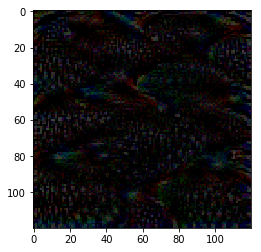

In [9]:
plt.imshow(img)

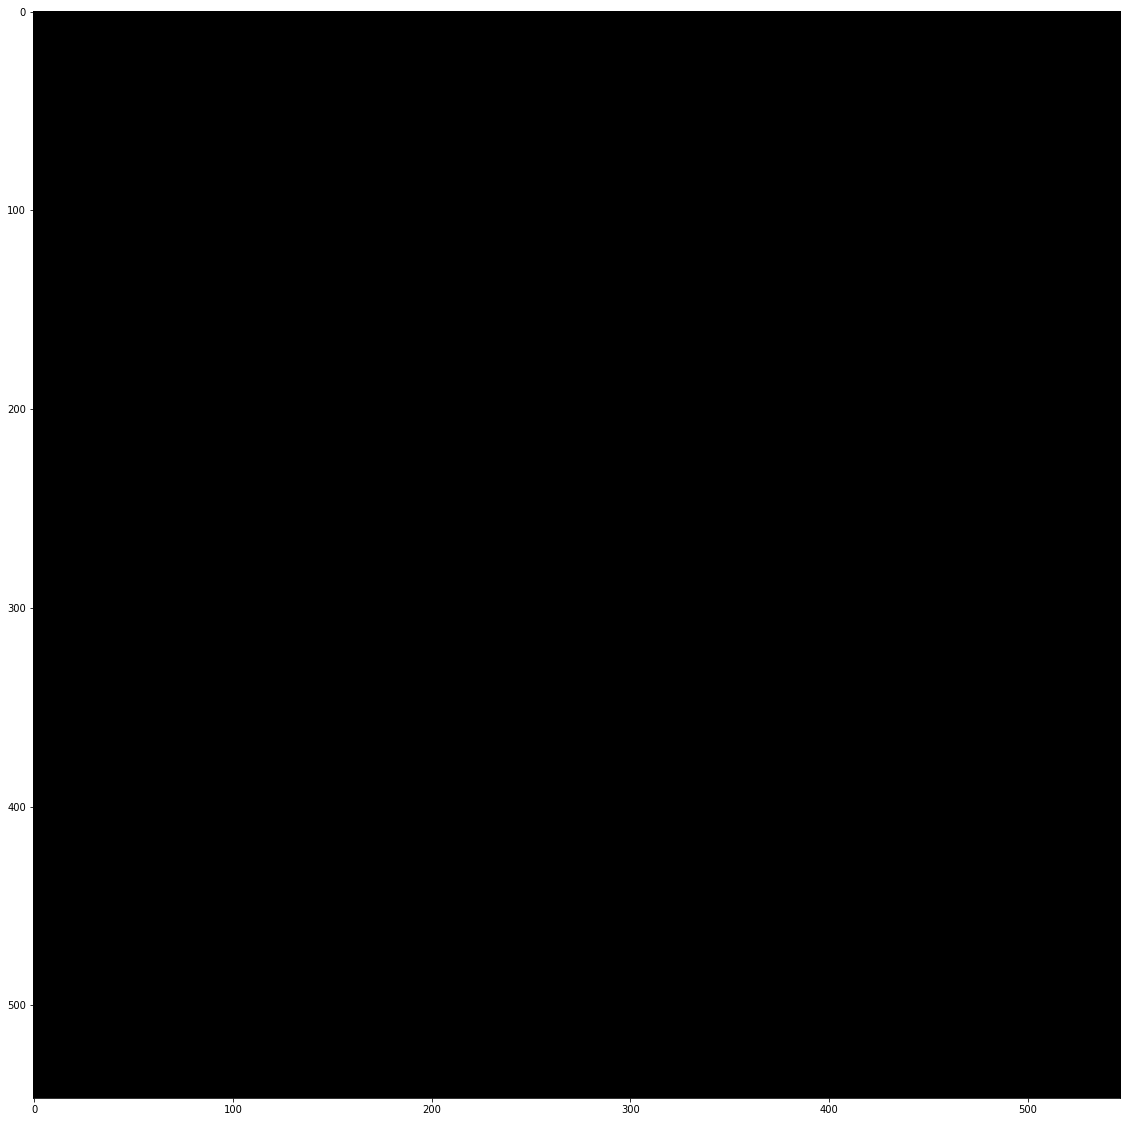

In [10]:
# plot 64 filters
img_size = 64
margin = 5

result = np.zeros((8*img_size+7*margin, 8*img_size+7*margin,3))

for i in range(8):
    for j in range(8):
        img_n = generate_pattern('block3_conv1', (i+j*8), img_size)
        img = preprocess_img(img_n)
        
        horizontal_start = i*img_size + i*margin
        horizontal_end = horizontal_start +img_size
        vertical_start = j*img_size + j*margin 
        vertical_end = vertical_start + img_size
        
plt.figure(figsize=(20,20))
plt.imshow(result)